* This notebook contains data cleaning, preprocessing text, train model with neural network

# Install Library

In [1]:
%%time

!pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 3.3 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=ff8e9b141f7ed8177be0babe0b0944dcaf10f6420fe0ae5935225db81998c5c8
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
CPU times: user 226 ms, sys: 61 ms, total: 287 ms
Wall time: 17.1 s


In [2]:
%%time

!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 903.9 kB/s eta 0:00:00:010m
CPU times: user 144 ms, sys: 49.1 ms, total: 193 ms
Wall time: 12.5 s


In [3]:
%%time

!pip install num2words

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 1.4 MB/s eta 0:00:00 0:00:01
CPU times: user 142 ms, sys: 41.9 ms, total: 184 ms
Wall time: 12.3 s


In [4]:
%%time

!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 44.6 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tsfresh 0.20.3 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
CPU times: user 281 ms, sys: 74.5 ms, t

# Load Files

In [5]:
%%time

import warnings
warnings.filterwarnings('ignore')

CPU times: user 40 µs, sys: 11 µs, total: 51 µs
Wall time: 53.4 µs


In [6]:
%%time

import numpy as np
import pandas as pd
import matplotlib
import scipy
import re
import os
from datasets import load_dataset, Dataset

from num2words import num2words
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from autocorrect import Speller
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

# ML imports:
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import fbeta_score
from sklearn.cluster import KMeans

# DL imports:
from transformers import AutoTokenizer, TrainingArguments, Trainer
from torch.utils.data import DataLoader
import evaluate

CPU times: user 22.4 s, sys: 2.17 s, total: 24.6 s
Wall time: 45.9 s


In [7]:
%%time

# Download necessary resources from NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corp

In [8]:
%%time

# Initialize the stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

CPU times: user 44 µs, sys: 5 µs, total: 49 µs
Wall time: 52.9 µs


In [9]:
%%time

score = pd.read_csv('/kaggle/input/jigsaw-toxic-severity-rating/comments_to_score.csv')
validation = pd.read_csv('/kaggle/input/jigsaw-toxic-severity-rating/validation_data.csv')
sample_submission = pd.read_csv('/kaggle/input/jigsaw-toxic-severity-rating/sample_submission.csv')

CPU times: user 273 ms, sys: 34 ms, total: 307 ms
Wall time: 651 ms


In [10]:
%%time

# Decode or remove

# Function to clean text data and handle encoding issues
def clean_text(text):
    # Remove encoding issues by normalizing and decoding potential artifacts
    cleaned_text = text.encode('ascii', 'ignore').decode('utf-8', 'ignore')  # Remove non-ASCII characters
    cleaned_text = cleaned_text.replace('\n', ' ').replace('\r', ' ')  # Replace newlines with spaces
    cleaned_text = cleaned_text.strip()  # Remove leading and trailing whitespace
    return cleaned_text

# Apply the cleaning function to the text column
score['text'] = score['text'].apply(clean_text)

CPU times: user 15.7 ms, sys: 838 µs, total: 16.5 ms
Wall time: 24.5 ms


In [11]:
%%time

# Apply lowercasing to the cleaned text column
score['text'] = score['text'].str.lower()

CPU times: user 4.47 ms, sys: 941 µs, total: 5.41 ms
Wall time: 5.26 ms


In [12]:
%%time

# Function to remove punctuation and special characters
def remove_punctuation_special_chars(text):
    # Remove all non-alphanumeric characters except spaces
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Apply the function to remove punctuation and special characters
score['text'] = score['text'].apply(remove_punctuation_special_chars)

CPU times: user 132 ms, sys: 0 ns, total: 132 ms
Wall time: 132 ms


In [13]:
%%time

# Get the list of English stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

# Apply the function to remove stopwords from the cleaned text
score['text'] = score['text'].apply(remove_stopwords)

CPU times: user 112 ms, sys: 844 µs, total: 113 ms
Wall time: 113 ms


In [14]:
%%time

# Function to apply stemming
def apply_stemming(text):
    words = text.split()
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

# Apply stemming
score['text'] = score['text'].apply(apply_stemming)

CPU times: user 9.49 s, sys: 3.61 ms, total: 9.49 s
Wall time: 9.49 s


In [15]:
%%time

# Function to apply lemmatization
def apply_lemmatization(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Apply lemmatization
score['text'] = score['text'].apply(apply_lemmatization)

CPU times: user 4.07 s, sys: 128 ms, total: 4.2 s
Wall time: 4.2 s


# Create New Labeled Data Using Clusters Method

In [16]:
%%time

# Use clusters to define label
text_data = score['text']

CPU times: user 110 µs, sys: 9 µs, total: 119 µs
Wall time: 123 µs


In [17]:
%%time

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Transform the text into TF-IDF features
X_tfidf = vectorizer.fit_transform(text_data)

CPU times: user 371 ms, sys: 5.92 ms, total: 377 ms
Wall time: 389 ms


In [18]:
%%time

# Cluster the text using K-means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_tfidf)

CPU times: user 3.03 s, sys: 119 ms, total: 3.15 s
Wall time: 851 ms


KMeans(n_clusters=3, random_state=42)

In [19]:
%%time

#  Define labels for each cluster
cluster_labels = {0: "positive", 1: "negative", 2: "neutral"}

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


In [20]:
%%time

# Initialize the list to store predicted labels
predicted_labels = []

# Process each sentence in the 'text' column of the score DataFrame
for sentence in score['text']:
    # Transform the preprocessed sentence into TF-IDF features
    features = vectorizer.transform([sentence])
    
    # Predict the cluster of the sentence
    cluster = kmeans.predict(features)
    
    # Get the label for the predicted cluster
    label = cluster_labels[cluster[0]]
    
    # Store the predicted label in the list
    predicted_labels.append(label)

CPU times: user 8.33 s, sys: 29.5 ms, total: 8.36 s
Wall time: 8.36 s


In [21]:
%%time

# Add the predicted labels as a new column to the original dataset 
score['predicted_label'] = predicted_labels

CPU times: user 1.21 ms, sys: 1.08 ms, total: 2.29 ms
Wall time: 2.93 ms


In [22]:
%%time

# Save the updated DataFrame to a CSV file
output_file_path = 'new_score.csv'  
score.to_csv(output_file_path, index=False)

CPU times: user 91.4 ms, sys: 1.01 ms, total: 92.4 ms
Wall time: 93.3 ms


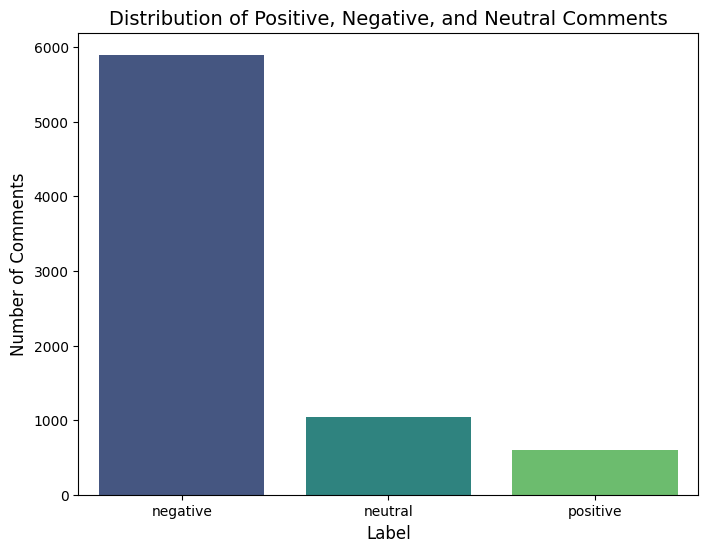

CPU times: user 521 ms, sys: 184 ms, total: 705 ms
Wall time: 576 ms


In [23]:
%%time

# Visualize the distribution of positive, negative, and neutral comments
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of occurrences of each label
label_counts = score['predicted_label'].value_counts()

# Set up the visualization
plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')

# Add labels and title
plt.title('Distribution of Positive, Negative, and Neutral Comments', fontsize=14)
plt.xlabel('Label', fontsize=12)
plt.ylabel('Number of Comments', fontsize=12)
plt.show()

* Positive Cluster : These comments might be praising something, expressing agreement, or generally using positive language

* Negative Cluster : These are likely to include complaints, criticisms, or disagreement

* Neutral Cluster : These comments are often factual, balanced, or may express mixed feelings

# Train Model With Neural Network

In [24]:
%%time

from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X = score['text']
y = score['predicted_label']  

CPU times: user 59 µs, sys: 3 µs, total: 62 µs
Wall time: 66.5 µs


In [25]:
%%time

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

CPU times: user 2.6 ms, sys: 0 ns, total: 2.6 ms
Wall time: 2.39 ms


In [26]:
%%time

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define the tokenizer and fit it on the training text
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure uniform length
X_train_padded = pad_sequences(X_train_seq, maxlen=100, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=100, padding='post', truncating='post')

CPU times: user 557 ms, sys: 8.95 ms, total: 566 ms
Wall time: 596 ms


In [27]:
%%time

# Correct the label mapping: map string labels to numeric values
label_mapping = {'positive': 0, 'negative': 1, 'neutral': 2}

# Convert the labels to numeric format using the mapping
y_train_num = y_train.map(label_mapping)
y_test_num = y_test.map(label_mapping)

CPU times: user 2.35 ms, sys: 0 ns, total: 2.35 ms
Wall time: 2.24 ms


In [28]:
%%time

from tensorflow.keras.utils import to_categorical

# One-hot encode the labels (multi-class classification)
y_train_cat = to_categorical(y_train_num)
y_test_cat = to_categorical(y_test_num)

CPU times: user 1.32 ms, sys: 891 µs, total: 2.21 ms
Wall time: 4.78 ms


In [29]:
%%time

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

# Define the neural network architecture
model = Sequential([
    Embedding(input_dim=10000, output_dim=16, input_length=100),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # Change to 3 for multi-class classification (positive, negative, neutral)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using the categorical labels
model.fit(X_train_padded, y_train_cat, epochs=5, batch_size=32, validation_data=(X_test_padded, y_test_cat))

Epoch 1/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.7670 - loss: 0.7429 - val_accuracy: 0.7546 - val_loss: 0.7184
Epoch 2/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7862 - loss: 0.6609 - val_accuracy: 0.7546 - val_loss: 0.7166
Epoch 3/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7988 - loss: 0.6357 - val_accuracy: 0.7546 - val_loss: 0.7237
Epoch 4/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7842 - loss: 0.6621 - val_accuracy: 0.7546 - val_loss: 0.7402
Epoch 5/5
189/189 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7932 - loss: 0.6419 - val_accuracy: 0.7580 - val_loss: 0.6728
CPU times: user 12.9 s, sys: 1.5 s, total: 14.4 s
Wall time: 12.5 s


In [30]:
%%time

from sklearn.metrics import confusion_matrix
import numpy as np

# Make predictions on the test set
y_pred = model.predict(X_test_padded)

# Convert predictions from one-hot encoding to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Convert true labels from one-hot encoding to class labels
y_true_labels = np.argmax(y_test_cat, axis=1)

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
CPU times: user 481 ms, sys: 29.4 ms, total: 511 ms
Wall time: 475 ms


In [31]:
%%time

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)

print(conf_matrix)

[[   0  128    1]
 [   1 1136    1]
 [   0  234    7]]
CPU times: user 4.69 ms, sys: 0 ns, total: 4.69 ms
Wall time: 3.75 ms


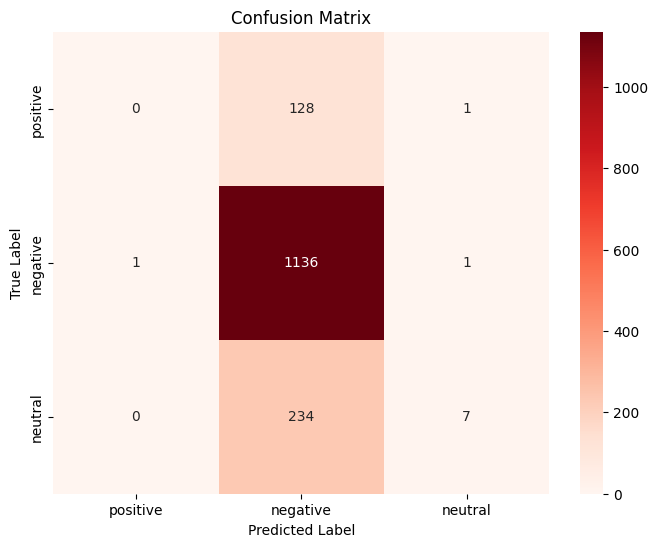

CPU times: user 390 ms, sys: 195 ms, total: 585 ms
Wall time: 315 ms


In [32]:
%%time

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', xticklabels=['positive', 'negative', 'neutral'], yticklabels=['positive', 'negative', 'neutral'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

From Results :

* The actual label is positive, but the model predicted negative for all 129 instances.

* The actual label is negative, and the model predicted negative for 1138 instances.

* The model predicted negative for 240 instance

*  Predicted neutral correctly for only 1 instance.

In [33]:
%%time

import tensorflow.keras.backend as K

# Custom metric for Average Agreement with Annotators 
def average_agreement_with_annotators(y_true, y_pred):
    # Round predictions to get the final predicted labels 
    y_pred_labels = K.argmax(y_pred, axis=-1)
    y_true_labels = K.argmax(y_true, axis=-1)

    # Check if predictions match the true labels (annotator consensus)
    agreement = K.equal(y_true_labels, y_pred_labels)
    
    # Calculate the mean agreement
    return K.mean(K.cast(agreement, K.floatx()))

# Compile the model with the custom metric
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', average_agreement_with_annotators])


# Calculate custom metric 
def calculate_aaa(y_true_labels, y_pred_labels):
    agreement = (y_true_labels == y_pred_labels).astype(int)
    aaa = np.mean(agreement)
    return aaa

# Calculate the custom metric using predicted and true labels
aaa_score = calculate_aaa(y_true_labels, y_pred_labels)

print(f"Average Agreement with Annotators: {aaa_score}")

Average Agreement with Annotators: 0.7579575596816976
CPU times: user 6.58 ms, sys: 987 µs, total: 7.57 ms
Wall time: 6.76 ms
